In [1]:
!pip install utils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install eofs

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install netCDF4

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! pip install netcdf4 xarray[io] cartopy nc-time-axis

Defaulting to user installation because normal site-packages is not writeable


In [6]:
!pip install -U scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install --user xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.1/297.1 MB 14.4 MB/s eta 0:00:0000:0100:01


In [9]:
!pip install utils

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import datetime as dt  # Python standard library datetime  module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import RandomizedSearchCV
from eofs.xarray import Eof
import utils
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import random

In [3]:
#get the test y data
test_inputs = pd.read_csv('test_data.csv').set_index('Unnamed: 0')
test_inputs

,CO2,CH4,SO2_0,SO2_1,SO2_2,SO2_3,SO2_4,BC_0,BC_1,BC_2,BC_3,BC_4
Unnamed: 0,,,,,,,,,,,,
2015,0.640030,0.622895,0.903505,2.331736,-0.104266,-1.138111,1.045259,2.706810,-1.375172,-0.819380,-0.256301,-1.716714
2016,0.655024,0.622868,0.857117,2.261433,0.078151,-1.083139,0.977491,2.648897,-1.303500,-0.707064,-0.314685,-1.616016
2017,0.670164,0.622841,0.810728,2.191129,0.260569,-1.028166,0.909724,2.590985,-1.231828,-0.594749,-0.373069,-1.515319
2018,0.685449,0.622814,0.764340,2.120826,0.442987,-0.973193,0.841956,2.533072,-1.160157,-0.482433,-0.431453,-1.414621
2019,0.700880,0.622787,0.717951,2.050522,0.625405,-0.918221,0.774188,2.475159,-1.088485,-0.370117,-0.489837,-1.313923
...,...,...,...,...,...,...,...,...,...,...,...,...
2096,1.859445,0.469562,0.178097,0.697813,1.189839,-0.064685,0.033707,0.434483,-0.189906,-0.115759,-0.230166,0.147331
2097,1.866250,0.468973,0.177501,0.687329,1.167448,-0.080802,0.006906,0.422541,-0.181722,-0.101978,-0.213992,0.169751
2098,1.872799,0.468383,0.176905,0.676844,1.145056,-0.096920,-0.019895,0.410599,-0.173539,-0.088197,-0.197818,0.192172


In [4]:
#get the test x data
test_X = xr.open_dataset('inputs_ssp245.nc').compute()
test_X

<xarray.Dataset>
Dimensions:    (time: 86, longitude: 144, latitude: 96)
Coordinates:
  * longitude  (longitude) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float64 -90.0 -88.11 -86.21 ... 86.21 88.11 90.0
  * time       (time) int64 2015 2016 2017 2018 2019 ... 2097 2098 2099 2100
Data variables:
    CO2        (time) float64 1.536e+03 1.572e+03 ... 4.51e+03 4.524e+03
    SO2        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    CH4        (time) float64 0.3737 0.3737 0.3737 ... 0.281 0.2807 0.2803
    BC         (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [5]:
test_Y = xr.open_dataset('outputs_ssp245.nc').compute()
test_Y

<xarray.Dataset>
Dimensions:                    (lat: 96, lon: 144, time: 86, member: 3)
Coordinates:
  * lat                        (lat) float64 -90.0 -88.11 -86.21 ... 88.11 90.0
  * lon                        (lon) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * time                       (time) int64 2015 2016 2017 ... 2098 2099 2100
    quantile                   float64 0.9
  * member                     (member) int64 1 2 3
Data variables:
    diurnal_temperature_range  (member, time, lat, lon) float32 0.1953 ... -0...
    tas                        (member, time, lat, lon) float32 1.601 ... 5.677
    pr                         (member, time, lat, lon) float32 9.877e-09 ......
    pr90                       (member, time, lat, lon) float64 -1.104e-07 .....

In [6]:
#extract each actual y variables
tas_truth = test_Y["tas"].mean('member')
pr_truth = test_Y["pr"].mean('member') * 86400
pr90_truth = test_Y["pr90"].mean('member') * 86400
dtr_truth = test_Y["diurnal_temperature_range"].mean('member')

In [7]:
# Utilities for normalizing the emissions data
min_co2 = 0.
max_co2 = 2400
def normalize_co2(data):
    return data / max_co2

def un_normalize_co2(data):
    return data * max_co2

min_ch4 = 0.
max_ch4 = 0.6
def normalize_ch4(data):
    return data / max_ch4

def un_normalize_ch4(data):
    return data * max_ch4

In [8]:
# Get one combined historical + ssp585 + ssp126 + ssp370 timeseries for now
X = xr.concat([xr.open_dataset('inputs_historical.nc'), xr.open_dataset('inputs_ssp585.nc'),xr.open_dataset('inputs_ssp126.nc'),xr.open_dataset('inputs_ssp370.nc'),xr.open_dataset('inputs_hist-aer.nc'),xr.open_dataset('inputs_hist-GHG.nc')], dim='time').compute()

# Take the average member for the historical, ssp585, ssp126, ssp370, hist-aer, hist-ghg
Y = xr.concat([xr.open_dataset('outputs_historical.nc').mean(dim="member"), xr.open_dataset('outputs_ssp585.nc').mean(dim="member"),xr.open_dataset('outputs_ssp126.nc').mean(dim="member"),xr.open_dataset('outputs_ssp370.nc').mean(dim="member"),xr.open_dataset('outputs_hist-aer.nc').mean(dim="member"),xr.open_dataset('outputs_hist-GHG.nc').mean(dim="member")], dim='time').compute()


# Convert the precip values to mm/day
Y["pr"] *= 86400
Y["pr90"] *= 86400

X["time"]=np.arange(1, 424 + 165 + 165) ## 165+86+86+86+65+165+1
Y["time"]=np.arange(1, 424 + 165 + 165)

In [9]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
bc_solver = Eof(X['BC'])

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
bc_eofs = bc_solver.eofsAsCorrelation(neofs=5)
bc_pcs = bc_solver.pcs(npcs=5, pcscaling=1)

In [10]:
# Create an EOF solver to do the EOF analysis. Square-root of cosine of
# latitude weights are applied before the computation of EOFs.
so2_solver = Eof(X['SO2'])

# Retrieve the leading EOF, expressed as the correlation between the leading
# PC time series and the input SST anomalies at each grid point, and the
# leading PC time series itself.
so2_eofs = so2_solver.eofsAsCorrelation(neofs=5)
so2_pcs = so2_solver.pcs(npcs=5, pcscaling=1)

In [11]:
# Convert the Principle Components of the aerosol emissions (calculated above) in to Pandas DataFrames
bc_df = bc_pcs.to_dataframe().unstack('mode')
bc_df.columns = [f"BC_{i}" for i in range(5)]

so2_df = so2_pcs.to_dataframe().unstack('mode')
so2_df.columns = [f"SO2_{i}" for i in range(5)]

In [12]:
# Bring the emissions data back together again and normalise
leading_historical_inputs = pd.DataFrame({
    "CO2": normalize_co2(X["CO2"].data),
    "CH4": normalize_ch4(X["CH4"].data)
}, index=X["CO2"].coords['time'].data)

# Combine with aerosol EOFs
leading_historical_inputs=pd.concat([leading_historical_inputs, bc_df, so2_df], axis=1)

In [13]:
y_inp_tas=Y["tas"].stack(dim=["lat", "lon"])
y_inp_pr=Y["pr"].stack(dim=["lat", "lon"])
y_inp_pr90=Y["pr90"].stack(dim=["lat", "lon"])
y_inp_dtr=Y["diurnal_temperature_range"].stack(dim=["lat", "lon"])

In [14]:
df_y_input_tas = pd.DataFrame(y_inp_tas.to_pandas())
df_y_input_pr = pd.DataFrame(y_inp_pr.to_pandas())
df_y_input_pr90 = pd.DataFrame(y_inp_pr90.to_pandas())
df_y_input_dtr = pd.DataFrame(y_inp_dtr.to_pandas())

Xy_train_tas_ = pd.concat([leading_historical_inputs, df_y_input_tas], axis=1)
Xy_train_pr_ = pd.concat([leading_historical_inputs, df_y_input_pr], axis=1)
Xy_train_pr90_ = pd.concat([leading_historical_inputs, df_y_input_pr90], axis=1)
Xy_train_dtr_ = pd.concat([leading_historical_inputs, df_y_input_dtr], axis=1)

In [15]:
Xy_train_tas = Xy_train_tas_.to_numpy()
Xy_train_pr = Xy_train_pr_.to_numpy()
Xy_train_pr90 = Xy_train_pr90_.to_numpy()
Xy_train_dtr = Xy_train_dtr_.to_numpy()

In [16]:
n_inp=leading_historical_inputs.shape[1]
n_iout=Xy_train_tas_.shape[1]

X_train_tas=Xy_train_tas[:,0:n_inp]
y_train_tas=Xy_train_tas[:,n_inp:n_iout]

X_train_pr=Xy_train_pr[:,0:n_inp]
y_train_pr=Xy_train_pr[:,n_inp:n_iout]

X_train_pr90=Xy_train_pr90[:,0:n_inp]
y_train_pr90=Xy_train_pr90[:,n_inp:n_iout]

X_train_dtr=Xy_train_dtr[:,0:n_inp]
y_train_dtr=Xy_train_dtr[:,n_inp:n_iout]

In [288]:
# #get the training data for tas
# Xy_train_tas = pd.read_csv('Xy_train_tas.csv').drop(columns = 'Unnamed: 0')
# Xy_train_tas

In [299]:
# X_train_tas=Xy_train_tas.iloc[:,0:12]#split training data of tas for x
# y_train_tas=Xy_train_tas.iloc[:,12:13836]#split training data of tas for y

In [17]:
#set up tas estimator
xgb_tas = xgb.XGBRegressor()

In [22]:
# param_grid = {
#     'learning_rate': np.linspace(0.01, 0.2, 10),
#     'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 300, num = 5)],
#     'max_depth': [int(x) for x in np.linspace(5, 20, num=4)],
#     'min_child_weight': [int(x) for x in np.linspace(1, 10, num=5)],
#     'subsample': np.linspace(0.8, 1.0, 5),
#     'colsample_bytree': np.linspace(0.8, 1.0, 5)
# }

In [17]:
param_grid1 = {
    'learning_rate': np.linspace(0.01, 0.2, 10),
    'n_estimators': [int(x) for x in np.linspace(start=100, stop=300, num=5)],
    'max_depth': [int(x) for x in np.linspace(5, 20, num=4)],
    'min_child_weight': [int(x) for x in np.linspace(1, 10, num=5)],  
    'subsample': np.linspace(0.8, 1.0, 5),
    'colsample_bytree': np.linspace(0.4, 1.0, 5),
    'gamma': np.linspace(0, 0.5, 6),  
}

In [19]:
random_search = RandomizedSearchCV(
    estimator=xgb_tas,
    param_distributions=param_grid1,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [20]:
random_search.fit(X_train_tas, y_train_tas)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=3, n_estimators=300, subsample=1.0; total time=13.7min
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=3, n_estimators=300, subsample=1.0; total time=11.2min
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=3, n_estimators=300, subsample=1.0; total time=12.0min
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=3, n_estimators=300, subsample=1.0; total time=12.7min
[CV] END colsample_bytree=0.7, gamma=0.2, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=3, n_estimators=300, subsample=1.0; total time=14.8min
[CV] END colsample_bytree=0.85, gamma=0.30000000000000004, learning_rate=0.07333333333333333, max_depth=15, min_child_weight

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.4 , 0.55, 0.7 , 0.85, 1.  ]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': [5, 10, 15, 20],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [21]:
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'subsample': 0.95, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 15, 'learning_rate': 0.07333333333333333, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.85}


In [22]:
#get the model with best parameter
best_xgb_tas = random_search.best_estimator_

In [23]:
pred_tas = best_xgb_tas.predict(test_inputs)
pred_tas

array([[0.8283349 , 0.86355704, 0.843159  , ..., 3.1390524 , 2.9742284 ,
        2.9210417 ],
       [0.8941014 , 0.9273006 , 0.86100835, ..., 3.1390524 , 3.0424707 ,
        2.941238  ],
       [0.8941014 , 0.9273006 , 0.8367205 , ..., 3.2022197 , 3.0549572 ,
        2.9604847 ],
       ...,
       [1.7817628 , 1.7605001 , 1.7567747 , ..., 6.6564584 , 6.396932  ,
        6.670207  ],
       [1.8245435 , 1.918173  , 1.871442  , ..., 6.6564584 , 6.396932  ,
        6.670207  ],
       [1.8505402 , 1.9367509 , 1.8907254 , ..., 6.6939263 , 6.396932  ,
        6.670207  ]], dtype=float32)

In [24]:
pred_tas = pred_tas.reshape(86,96,144)

In [25]:
def rmse(truth, pred):
    weights = np.cos(np.deg2rad(truth.lat))
    return np.sqrt(((truth-pred)**2).weighted(weights).mean(['lat', 'lon'])).data.mean()
def global_mean(ds):
    if 'lat' not in ds.coords:
        ds_ = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
    else:
        ds_ = ds
    weights = np.cos(np.deg2rad(ds_.lat))
    return ds_.weighted(weights).mean(['lat', 'lon'])
def get_rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))

In [26]:
#create xr dataset
xr_output=xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output["tas"]=(['time', 'lat', 'lon'],  pred_tas)

In [27]:
#create xr data for tas
xr_output_tas = xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_tas["tas"]=(['time', 'lat', 'lon'],  pred_tas)

In [28]:
from xskillscore import rmse
weights = np.cos(np.deg2rad(test_Y['tas'].lat)).expand_dims(lon=144).assign_coords(lon=test_Y.lon)

In [31]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import transforms

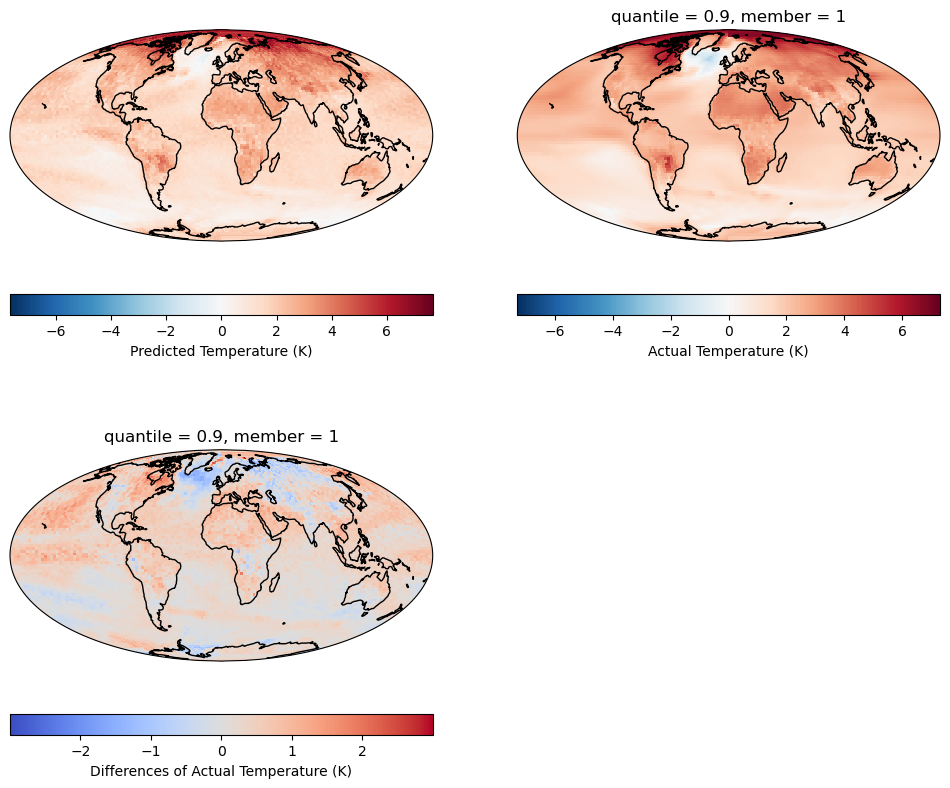

In [32]:
#getting plot for the predicted temperature
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output_tas['tas'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the actual temperature
plt.subplot(222,projection=ccrs.Mollweide())
test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()
#getting plot for the differences
diff_tas = test_Y["tas"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output_tas['tas'].sel(time=slice(2080, 2100)).mean(['time'])
plt.subplot(223, projection=ccrs.Mollweide())
diff_tas.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Actual Temperature (K)", "orientation":'horizontal'})
plt.gca().coastlines()

In [316]:
# #get the training data for dtr
# Xy_train_dtr = pd.read_csv('Xy_train_dtr.csv').drop(columns = 'Unnamed: 0')
# Xy_train_dtr

In [317]:
# X_train_dtr=Xy_train_dtr.iloc[:,0:12]#split training data of dtr for x
# y_train_dtr=Xy_train_dtr.iloc[:,12:13836]#split training data of dtr for y

In [33]:
#set up dtr estimator
xgb_dtr = xgb.XGBRegressor()

In [34]:
random_search_dtr = RandomizedSearchCV(
    estimator=xgb_dtr,
    param_distributions=param_grid1,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [35]:
random_search_dtr.fit(X_train_dtr, y_train_dtr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.052222222222222225, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=12.2min
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.052222222222222225, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=12.4min
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.052222222222222225, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=10.1min
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.052222222222222225, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=11.2min
[CV] END colsample_bytree=1.0, gamma=0.5, learning_rate=0.052222222222222225, max_depth=10, min_child_weight=5, n_estimators=300, subsample=1.0; total time=14.7min
[CV] END colsample_bytree=0.4, gamma=0.4, learning_rate=0.052222222222222225, max_depth=5, min_child_weight=5, n_estima

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.4 , 0.55, 0.7 , 0.85, 1.  ]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': [5, 10, 15, 20],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [36]:
print("Best Hyperparameters:", random_search_dtr.best_params_)

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 10, 'learning_rate': 0.052222222222222225, 'gamma': 0.5, 'colsample_bytree': 1.0}


In [37]:
#get the model with best parameter
best_xgb_dtr = random_search_dtr.best_estimator_

In [40]:
pred_dtr = best_xgb_dtr.predict(test_inputs)

In [41]:
pred_dtr = pred_dtr.reshape(86,96,144)

In [45]:
xr_output["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  pred_dtr)

In [48]:
#create xr data for dtr
xr_output_dtr = xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_dtr["diurnal_temperature_range"]=(['time', 'lat', 'lon'],  pred_dtr)

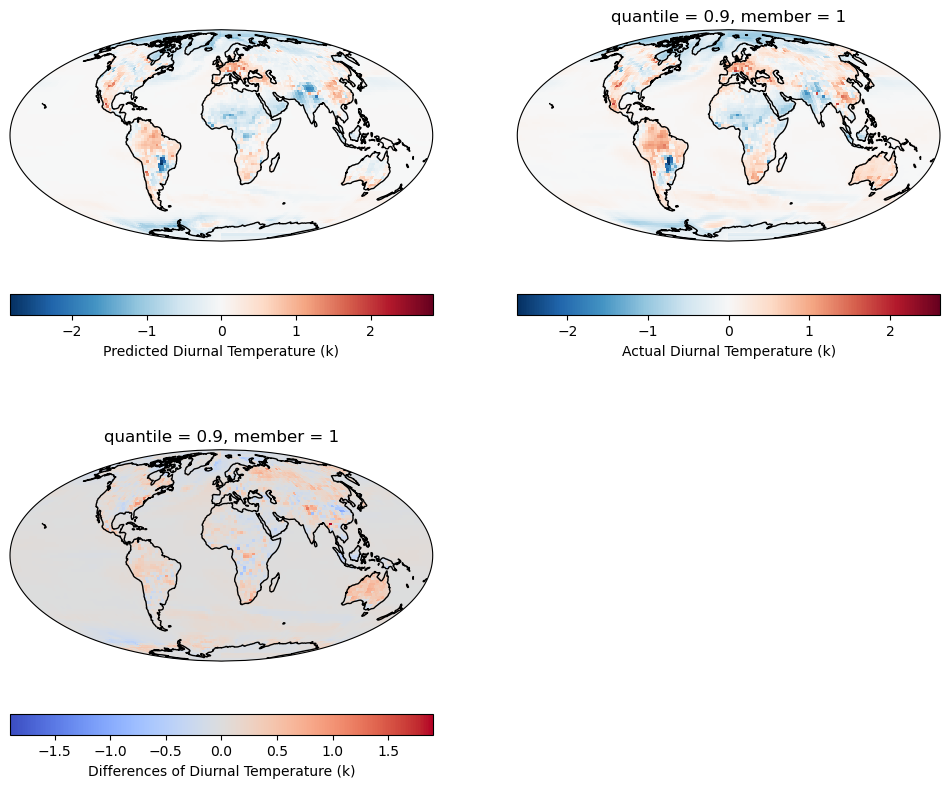

In [49]:
#getting plot for the predicted dtr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['diurnal_temperature_range'].sel(time=slice(2080, 2100)).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual dtr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']).plot(transform=ccrs.PlateCarree(),
                                                                     cbar_kwargs={"label":"Actual Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs differences between actual and predicted dtr
diff_dtr = test_Y["diurnal_temperature_range"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output["diurnal_temperature_range"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_dtr.plot(cmap='coolwarm', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Diurnal Temperature (k)", "orientation":'horizontal'})
plt.gca().coastlines()

In [334]:
# #get the training data for pr
# Xy_train_pr = pd.read_csv('Xy_train_pr.csv').drop(columns = 'Unnamed: 0')
# Xy_train_pr

In [335]:
# X_train_pr=Xy_train_pr.iloc[:,0:12]#split training data of pr for x
# y_train_pr=Xy_train_pr.iloc[:,12:13836]#split training data of pr for y

In [336]:
# #convert pr into regression matrix
# train_pr = xgb.DMatrix(X_train_pr, y_train_pr)

In [50]:
#set up pr estimator
xgb_pr = xgb.XGBRegressor()

In [51]:
random_search_pr = RandomizedSearchCV(
    estimator=xgb_pr,
    param_distributions=param_grid1,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [52]:
random_search_pr.fit(X_train_pr, y_train_pr)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.55, gamma=0.1, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.95; total time=18.8min
[CV] END colsample_bytree=0.55, gamma=0.1, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.95; total time=10.8min
[CV] END colsample_bytree=0.55, gamma=0.1, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.95; total time=11.2min
[CV] END colsample_bytree=0.55, gamma=0.1, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.95; total time=12.5min
[CV] END colsample_bytree=0.55, gamma=0.1, learning_rate=0.09444444444444444, max_depth=10, min_child_weight=5, n_estimators=300, subsample=0.95; total time=13.9min
[CV] END colsample_bytree=0.4, gamma=0.0, learning_rate=0.052222222222222225, max_depth=10, min_child_weight=7, n_

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.4 , 0.55, 0.7 , 0.85, 1.  ]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': [5, 10, 15, 20],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [53]:
print("Best Hyperparameters:", random_search_pr.best_params_)

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 7, 'max_depth': 15, 'learning_rate': 0.052222222222222225, 'gamma': 0.4, 'colsample_bytree': 0.55}


In [54]:
best_xgb_pr = random_search_pr.best_estimator_

In [55]:
pred_pr = best_xgb_pr.predict(test_inputs)

In [56]:
pred_pr = pred_pr.reshape(86, 96, 144)

In [57]:
test_Y["pr"] *= 86400
test_Y["pr90"] *= 86400

In [59]:
xr_output["pr"]=(['time', 'lat', 'lon'],  pred_pr)

In [92]:
#create xr dataset for pr
xr_output_pr = xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_pr["pr"]=(['time', 'lat', 'lon'],  pred_pr)

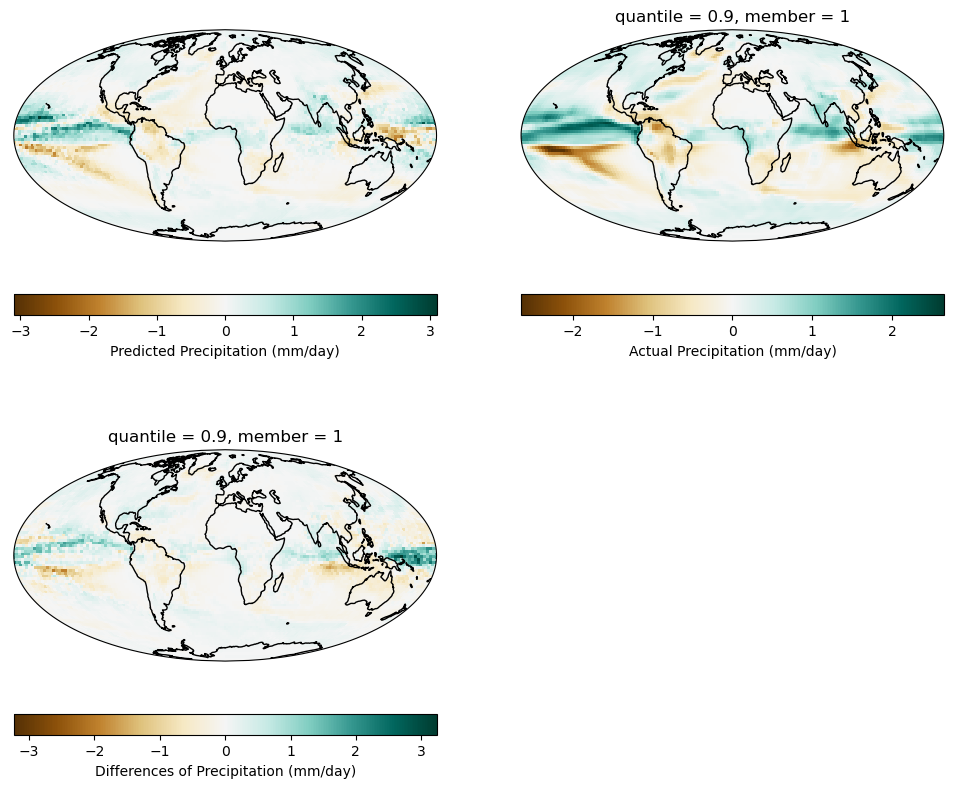

In [63]:
#getting plot for the predicted pr
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['pr'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr
diff_pr = test_Y["pr"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output["pr"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

In [353]:
# #get the training data for pr90
# Xy_train_pr90 = pd.read_csv('Xy_train_pr90.csv').drop(columns = 'Unnamed: 0')
# Xy_train_pr90

In [359]:
# X_train_pr90=Xy_train_pr90.iloc[:,0:12]#split training data of tas for x
# y_train_pr90=Xy_train_pr90_.iloc[:,12:13836]#split training data of tas for y

In [18]:
#set up pr90 estimator
xgb_pr90 = xgb.XGBRegressor()

In [19]:
random_search_pr90 = RandomizedSearchCV(
    estimator=xgb_pr90,
    param_distributions=param_grid1,
    n_iter=10,  # Number of parameter settings that are sampled
    scoring='neg_mean_squared_error',  # Use negative RMSE as scoring metric
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Print progress information
    n_jobs=-1  # Use all available CPU cores
)

In [20]:
random_search_pr90.fit(X_train_pr90, y_train_pr90)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.03111111111111111, max_depth=15, min_child_weight=1, n_estimators=250, subsample=1.0; total time=28.7min
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.03111111111111111, max_depth=15, min_child_weight=1, n_estimators=250, subsample=1.0; total time=26.0min
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.03111111111111111, max_depth=15, min_child_weight=1, n_estimators=250, subsample=1.0; total time=30.3min
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.03111111111111111, max_depth=15, min_child_weight=1, n_estimators=250, subsample=1.0; total time=34.5min
[CV] END colsample_bytree=0.4, gamma=0.5, learning_rate=0.03111111111111111, max_depth=15, min_child_weight=1, n_estimators=250, subsample=1.0; total time=36.3min
[CV] END colsample_bytree=0.55, gamma=0.1, learning_rate=0.11555555555555555, max_depth=15, min_child_weight=7, n_estimators

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                   param_distributions={'colsample_bytree': array([0.4 , 0.55, 0.7 , 0.85, 1.  ]),
                                        'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'learning_rate': array([0.01      , 0.03111111, 0.05222222, 0.07333333, 0.09444444,
       0.11555556, 0.13666667, 0.15777778, 0.17888889, 0.2       ]),
                                        'max_depth': [5, 10, 15, 20],
                                        'min_child_weight': [1, 3, 5, 7, 10],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300],
                                        'subsample': array([0.8 , 0.85, 0.9 , 0.95, 1.  ])},
                   scoring='neg_mean_squared_error', verbose=2)

In [21]:
print("Best Hyperparameters:", random_search_pr90.best_params_)

Best Hyperparameters: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 10, 'max_depth': 15, 'learning_rate': 0.01, 'gamma': 0.30000000000000004, 'colsample_bytree': 0.7}


In [22]:
#get the model with best parameter
best_xgb_pr90 = random_search_pr90.best_estimator_

In [24]:
pred_pr90 = best_xgb_pr90.predict(test_inputs)

In [25]:
pred_pr90 = pred_pr90.reshape(86, 96, 144)

In [243]:
# #getting rmse for predicted y and actual y
# print(f"RMSE: {rmse(pr90_truth[35], pred_pr901[35])}")
# print(f"RMSE: {rmse(pr90_truth[85], pred_pr901[85])}")
# print(f"RMSE: {rmse(pr90_truth[30:40], pred_pr901[30:40])}")
# print(f"RMSE: {rmse(pr90_truth[75:], pred_pr901[75:])}")
# print(f"RMSE: {rmse(pr90_truth[35:], pred_pr901[35:])}")
# print("\n")

In [244]:
xr_output["pr90"]=(['time', 'lat', 'lon'],  pred_pr90)

In [29]:
#create xr dataset for pr90
xr_output_pr90 = xr.Dataset(coords={'time': test_X.time.values, 'lat': test_X.latitude.values, 'lon': test_X.longitude.values})
xr_output_pr90["pr90"]=(['time', 'lat', 'lon'],  pred_pr90)

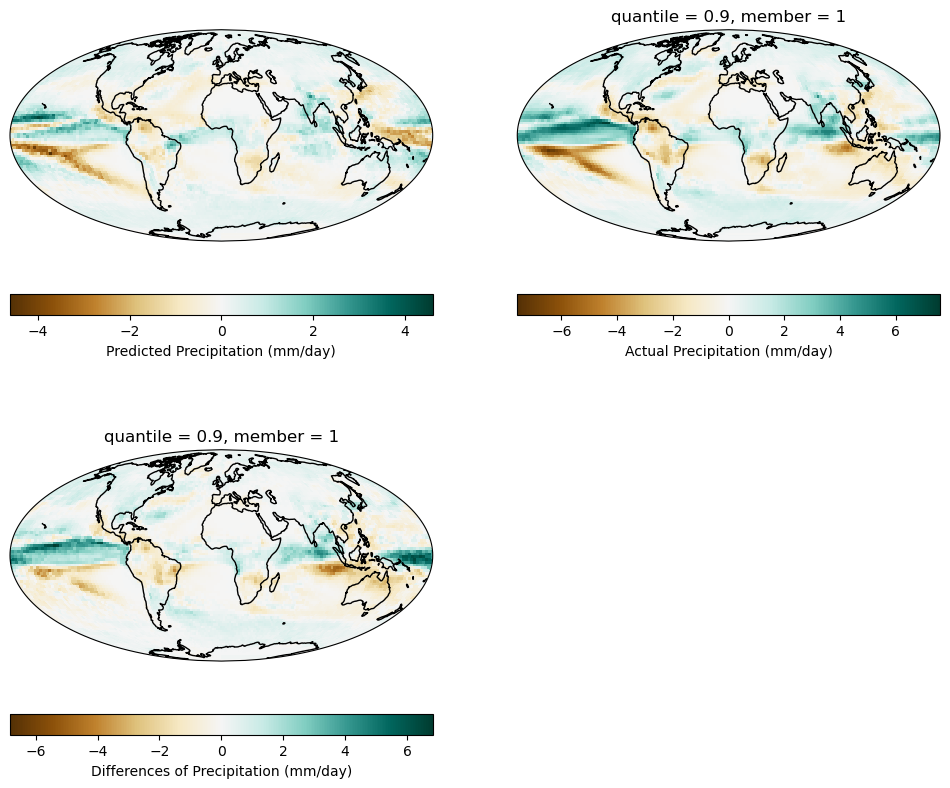

In [249]:
#getting plot for the predicted pr90
fig = plt.figure(figsize=(12, 10))
plt.subplot(221, projection=ccrs.Mollweide())
xr_output['pr90'].sel(time=slice(2080, 2100)).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Predicted Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting plot for the actual pr90

plt.subplot(222, projection=ccrs.Mollweide())
test_Y['pr90'].sel(time=slice(2080, 2100),member=1).mean(['time']).plot(cmap="BrBG", transform=ccrs.PlateCarree(),
                                                                cbar_kwargs={"label":"Actual Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

#getting the abs difference between actual and predicted pr90
diff_pr = test_Y["pr90"].sel(time=slice(2080,2100),member=1).mean(['time']) - xr_output["pr90"].sel(time=slice(2080, 2100)).mean(['time'])

plt.subplot(223, projection=ccrs.Mollweide())
diff_pr.plot(cmap='BrBG', transform=ccrs.PlateCarree(),cbar_kwargs={"label":"Differences of Precipitation (mm/day)", "orientation":'horizontal'})
plt.gca().coastlines()

In [253]:
# xr_output.to_netcdf('xr_output_xgboost.nc')

In [84]:
xr_output_tas.to_netcdf('xgboost_predicted_tas.nc')

In [85]:
xr_output_dtr.to_netcdf('xgboost_predicted_dtr.nc')

In [97]:
xr_output_pr.to_netcdf('xgboost_predicted_pr.nc')

In [30]:
xr_output_pr90.to_netcdf('xgboost_predicted_pr90.nc')

In [ ]:
# print(1)